# **Capitulo 6 – Ensemble Learning and Random Forests**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/ensembles` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


Supongamos que se plantea una pregunta compleja a miles de personas al azar y luego se agregan sus respuestas. En muchos casos, la respuesta agregada es mejor que la de un experto. Es lo que se llama la sabiduría de la multitud. Del mismo modo, si agrega las predicciones de un grupo de predictores (como clasificadores o regresores), a menudo obtendrá mejores predicciones que con el mejor predictor individual. Un grupo de predictores se denomina emsemble; por lo tanto, esta técnica se denomina aprendizaje de emsemble, y un algoritmo de aprendizaje de emsemble se denomina método de emsemble.

Como ejemplo de un método de emsemble, puede entrenar un grupo de clasificadores de árbol de decisión, cada uno en un subconjunto aleatorio diferente del emsemble de entrenamiento. A continuación, puede obtener las predicciones de todos los árboles individuales, y la clase que obtenga más votos será la predicción del emsemble. Este emsemble de árboles de decisión se denomina Random Forest y, a pesar de su simplicidad, es uno de los algoritmos de aprendizaje automático más potentes de la actualidad.

A menudo utilizará métodos de ensamblaje al final de un proyecto, una vez que haya construido unos cuantos buenos predictores, para combinarlos en un predictor aún mejor. De hecho, las soluciones ganadoras en los concursos de aprendizaje automático suelen incluir varios métodos ensemble.

En este Notebook examinaremos los métodos de ensamblaje más populares, incluidos los clasificadores bagging and pasting ensembles, random forests, y boosting, y stacking ensembles.

# Voting Classifiers

Supongamos que ha entrenado unos cuantos clasificadores, cada uno de los cuales alcanza un 80% de precisión. Es posible que tenga un clasificador de regresión logística, un clasificador SVM, un clasificador de random forest classifier, a k-nearest neighbors classifier y quizás algunos más.

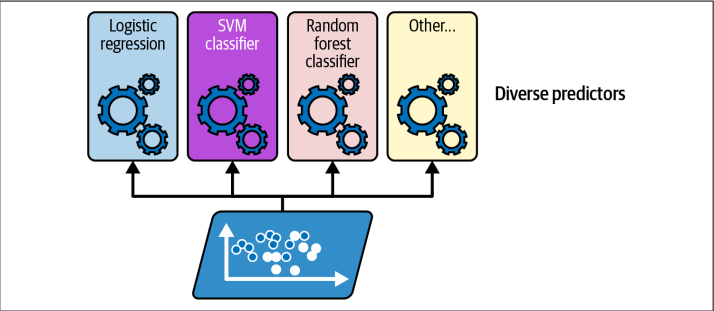


Una forma muy sencilla de crear un clasificador aún mejor es agregar las predicciones de cada clasificador: la clase que obtiene más votos es la predicción de ensemble’s. Este clasificador por mayoría de votos se denomina clasificador de hard voting.

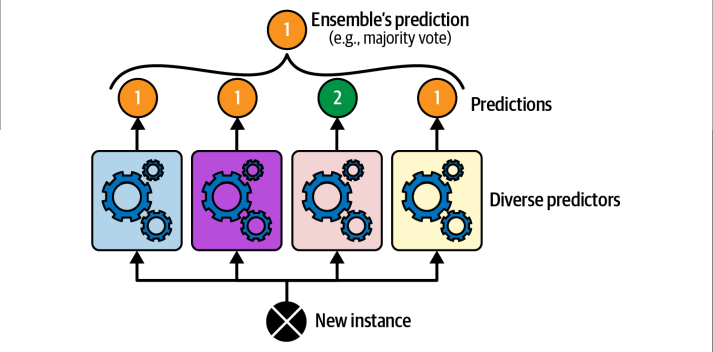

Sorprendentemente, este clasificador por votación suele alcanzar una precisión mayor que el mejor clasificador del ensemble. De hecho, incluso si cada clasificador es un aprendiz débil (lo que significa que lo hace sólo ligeramente mejor que la adivinación aleatoria), el ensemble puede seguir siendo un aprendiz fuerte (logrando una alta precisión), siempre que haya un número suficiente de aprendices débiles en el ensemble y que sean lo suficientemente diversos.

¿Cómo es posible? La siguiente analogía puede arrojar algo de luz sobre este misterio. Supongamos que tenemos una moneda ligeramente sesgada que tiene un 51% de posibilidades de salir cara y un 49% de salir cruz. Si la lanza 1.000 veces, obtendrá más o menos 510 caras y 490 cruces y, por tanto, una mayoría de caras. Si haces cuentas, verás que la probabilidad de obtener una mayoría de caras después de 1.000 lanzamientos es cercana al 75%. Cuanto más lances la moneda, mayor será la probabilidad (por ejemplo, con 10.000 lanzamientos, la probabilidad supera el 97%). Esto se debe a la ley de los grandes números: a medida que sigues lanzando la moneda, la proporción de caras se acerca cada vez más a la probabilidad de cara (51%). La figura a continuación muestra 10 series de lanzamientos sesgados de la moneda. Puede ver que, a medida que aumenta el número de lanzamientos, la proporción de caras se acerca al 51%. Finalmente, las 10 series terminan tan cerca del 51% que se sitúan sistemáticamente por encima del 50%.

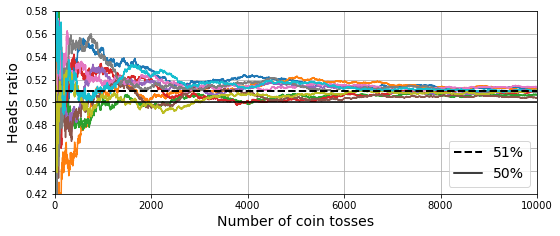

In [5]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

Del mismo modo, supongamos que creamos un conjunto de 1.000 clasificadores que sólo aciertan el 51% de las veces (apenas mejor que las suposiciones aleatorias). Si predice la clase más votada, ¡puede esperar una precisión de hasta el 75%! Sin embargo, esto sólo es cierto si todos los clasificadores son perfectamente independientes, cometiendo errores no correlacionados, lo que claramente no es el caso porque están entrenados con los mismos datos. Es probable que cometan los mismos tipos de errores, por lo que habrá muchos votos mayoritarios para la clase equivocada, lo que reducirá la precisión del ensemble’s.

Los métodos de ensemble funcionan mejor cuando los predictores son lo más independientes posible entre sí. Una forma de conseguir clasificadores diversos es entrenarlos utilizando algoritmos muy diferentes. Esto aumenta la probabilidad de que cometan tipos de errores muy diferentes, lo que mejora la precisión del conjunto.


Scikit-Learn provides a VotingClassifier class that’s quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier. Let’s try it on the moons dataset (introduced in Chapter 5). We will load and split the moons dataset into a training set and a test set, then we’ll create and train a voting classifier composed of three diverse classifiers:
Scikit-Learn proporciona una clase VotingClassifier bastante fácil de usar: basta con darle una lista de pares nombre/predictor y utilizarla como un clasificador normal. Vamos a probarlo con el conjunto de datos lunas. Cargaremos y dividiremos el conjunto de datos de lunas en un conjunto de entrenamiento y un conjunto de prueba, luego crearemos y entrenaremos un clasificador de votación compuesto por tres clasificadores diversos:

Construyamos un clasificador de votación:

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Cuando se ajusta un VotingClassifier, éste clona cada estimador y ajusta los clones. Los estimadores originales están disponibles a través del atributo estimators, mientras que los clones ajustados están disponibles a través del atributo estimators_. Si prefiere un dict en lugar de una lista, puede utilizar named_estimators o named_estimators_ en su lugar. Para empezar, veamos la precisión de cada clasificador ajustado en el conjunto de prueba:


In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


Cuando se llama al método predict() del clasificador de votación, éste realiza una hard voting. Por ejemplo, el clasificador de votación predice la clase 1 para la primera instancia del conjunto de prueba, porque dos de cada tres clasificadores predicen esa clase:


In [8]:
voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

Veamos ahora el rendimiento del clasificador por votación en el conjunto de pruebas:

In [10]:
voting_clf.score(X_test, y_test)

0.912

Ahí lo tienen. El clasificador por votación supera a todos los clasificadores individuales.

Si todos los clasificadores son capaces de estimar las probabilidades de clase (es decir, si todos tienen un método predict_proba()), entonces puede decirle a Scikit-Learn que prediga la clase con la mayor probabilidad de clase, promediada sobre todos los clasificadores individuales. Esto se denomina soft voting. A menudo logra un mayor rendimiento que la hard voting porque da más peso a los votos de alta confianza. Todo lo que tiene que hacer es establecer el hiperparámetro de voting del clasificador de votación en "soft" y asegurarse de que todos los clasificadores pueden estimar las probabilidades de clase. Este no es el caso de la clase SVC por defecto, por lo que necesitas establecer su hiperparámetro de probabilidad a True (esto hará que la clase SVC utilice la validación cruzada para estimar las probabilidades de clase, ralentizando el entrenamiento, y añadirá un método predict_proba()). Vamos a intentarlo:

Ahora usemos el soft voting:

In [11]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

Alcanzamos un 92% de precisión simplemente utilizando el soft voting: ¡nada mal!